https://pytorch.org/vision/main/models/resnet.html

https://pytorch.org/vision/main/models/efficientnet.html

https://pytorch.org/vision/main/models/convnext.html

In [1]:
import torch
import torchvision

from torchvision import models
from torchsummary import summary

In [2]:
import os
import deep_fashion

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

from torch.utils.data import DataLoader
from torchvision.transforms import Resize, Lambda, Compose

import torch
import utils

import time

---

In [3]:
weights = torchvision.models.ResNet50_Weights.DEFAULT
model = torchvision.models.resnet50(weights=weights)

---

In [4]:
ctsrbm_image_transform = Compose([
    Lambda(lambda img: img.repeat(3, 1, 1) if img.size(dim=0) == 1 else img),
    Resize(size=(256, 256), antialias=True)
])
ctsrbm_dataset_dir = os.path.join("..", "fashion_datasets_raw", "DeepFashion", "ConsumerToShop_Retrieval_BM")
ctsrbm_dataset = deep_fashion.ConsToShopClothRetrBM(ctsrbm_dataset_dir, ctsrbm_image_transform)

In [5]:
img, cat, attr = capbm_dataset[0]

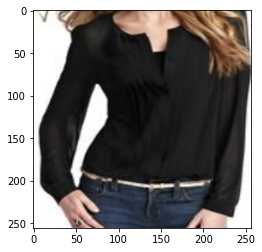

torch.Size([3, 256, 256])
0 80.80255635579427 255


In [6]:
plt.imshow(img.permute(1, 2, 0))
plt.show()

print(img.shape)
print(img.min().item(), img.double().mean().item(), img.max().item())

In [7]:
img_trans = torchvision.models.ResNet50_Weights.DEFAULT.transforms()(img)

/home/gerard/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


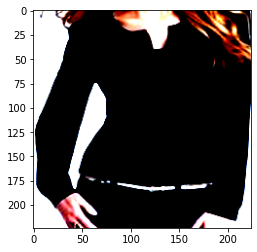

torch.Size([3, 224, 224])
-2.1007792949676514 -0.7157176195123952 2.640000104904175


In [8]:
plt.imshow(img_trans.permute(1, 2, 0))
plt.show()

print(img_trans.shape)
print(img_trans.min().item(), img_trans.double().mean().item(), img_trans.max().item())

In [9]:
img_trans_2 = img_trans[None, :]
print(img_trans_2.shape)

torch.Size([1, 3, 224, 224])


---

In [10]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [11]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model.layer4[2].relu.register_forward_hook(get_activation('layer4[2].relu'))
model.layer4.register_forward_hook(get_activation('layer4'))
model.avgpool.register_forward_hook(get_activation('avgpool'))
model.fc.register_forward_hook(get_activation('fc'))

In [12]:
output = model(img_trans_2)

In [13]:
for key, item in activation.items():
    print("{:20s} {:}".format(key, item.shape))

layer4[2].relu       torch.Size([1, 2048, 7, 7])
layer4               torch.Size([1, 2048, 7, 7])
avgpool              torch.Size([1, 2048, 1, 1])
fc                   torch.Size([1, 1000])


---

In [14]:
import backbones

In [15]:
backbone = backbones.ResNet50Backbone()

In [16]:
output = backbone(img_trans_2)

In [17]:
output.shape

torch.Size([1, 2048, 7, 7])

---

In [101]:
tensor = torch.Tensor([
    [1, 2, 3, 4, 5],
    [1, 3, 5, 7, 9],
    [1, 4, 7, 10, 13],
    [1, 5, 9, 13, 17],
    [1, 6, 11, 16, 21]
])

tensor = tensor[None, None, :]

In [102]:
tensor.shape

torch.Size([1, 1, 5, 5])

In [103]:
tensor

tensor([[[[ 1.,  2.,  3.,  4.,  5.],
          [ 1.,  3.,  5.,  7.,  9.],
          [ 1.,  4.,  7., 10., 13.],
          [ 1.,  5.,  9., 13., 17.],
          [ 1.,  6., 11., 16., 21.]]]])

In [104]:
tensor = tensor.repeat(1, 3, 1, 1)

In [105]:
tensor.shape

torch.Size([1, 3, 5, 5])

In [107]:
convolution = torch.nn.Conv2d(3, 3, 5)

In [108]:
convolution.weight.shape

torch.Size([3, 3, 5, 5])

In [91]:
convolution.bias.shape

torch.Size([5])

In [92]:
convolution.weight.requires_grad = False
convolution.bias.requires_grad = False

In [95]:
convolution.weight[:] = 1
convolution.bias[:] = 0

In [97]:
convolution.bias

Parameter containing:
tensor([0., 0., 0., 0., 0.])

In [98]:
tensor_new = convolution(tensor)

In [99]:
tensor_new.shape

torch.Size([1, 5, 1, 1])

In [100]:
tensor_new

tensor([[[[875.]],

         [[875.]],

         [[875.]],

         [[875.]],

         [[875.]]]])